In [2]:
#IMPORTING SETUP PACKAGES
import statsmodels.formula.api as smf
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)

In [3]:
number_of_top_items = '3000'
plot_name = number_of_top_items[0] + 'k'

#print(plot_name)

df = pd.read_pickle('/Users/gabriele.sabato/PycharmProjects/raw_data/DataFrames/Top'+number_of_top_items+'_seller_YTD_group_by_item_visit.pickle')


In [4]:
print(df.item_code.nunique())



2713


In [5]:
print(df.dtypes)

min_date                  object
max_date                  object
item_code                 object
item_price               float64
delivery_weeks             int64
avg_sales                float64
avg_unique_views         float64
conv_rate                float64
bin                        int32
item_parent_item_code     object
item_main_category        object
item_sub_category_1       object
item_sub_category_2       object
log_price                float64
log_delivery_weeks       float64
log_sales                float64
log_avg_unique_views     float64
log_conv_rate            float64
dtype: object


In [6]:
def filter_df(DF = df,bins=6, avg_PDP = 19.):
    df_filt = DF[DF['bin'] > bins]
    df_items = df_filt.groupby('item_code').item_price.nunique() > 1
    df_filt  = df_filt.merge(df_items,on='item_code',how='inner')
    df_filt  = df_filt[df_filt['item_price_y']== True]
    #filter PDP
    #print(df_filt)
    df_filt = df_filt[df_filt['avg_unique_views'] > avg_PDP]
    #print(df_filt)
    return df_filt

In [7]:
df_filt = filter_df(df)


print(df_filt.item_code.nunique())

2378


In [8]:
#introducing the similarity score 
sim_score = pd.read_parquet('/Users/gabriele.sabato/PycharmProjects/raw_data/recommendations_prod/part-00000-5f77392a-0bfa-4f0b-a4ae-d816ce2d71de-c000.snappy.parquet')

In [9]:
sim_score

,sku,recommended_sku,score
0,000000001000200072,000000001000200087,0.260000
1,000000001000200072,000000001000183538,0.216580
2,000000001000200072,000000001000142209,0.200000
3,000000001000200072,000000001000204906,0.190794
4,000000001000200072,000000001000183468,0.183980
...,...,...,...
3827600,000000001000064787,000000001000115010,0.203238
3827601,000000001000064787,000000001000112641,0.201339
3827602,000000001000064787,000000001000046204,0.200052
3827603,000000001000064787,000000001000114086,0.199867


In [10]:
# Filter table with only topX item_code

unique_item_codes = list(df_filt.item_code.unique())


sim_score_filt = sim_score[sim_score['sku'].isin(unique_item_codes)]

sim_score_filt

,sku,recommended_sku,score
820,000000001000180146,000000001000180137,0.904849
821,000000001000180146,000000001000180888,0.448651
822,000000001000180146,000000001000192222,0.381316
823,000000001000180146,000000001000031296,0.321612
824,000000001000180146,000000001000176646,0.278406
...,...,...,...
3827360,000000001000176744,000000001000171107,0.339302
3827361,000000001000176744,000000001000163202,0.335340
3827362,000000001000176744,000000001000163190,0.327887
3827363,000000001000176744,000000001000176438,0.324293


In [11]:
#Create a map with X subset for X linear fit:

def create_map(list_of_items = unique_item_codes , df=sim_score_filt, score_cut = 0.):
    map_of_items = {}
    for item_code in list_of_items:
        df_mod = df[df['sku'] == item_code]
        df_score_filt = df_mod[df_mod['score'] > score_cut]
        final_set_sku = list(df_score_filt.recommended_sku)
        final_set_sku.insert(0,item_code)
        map_of_items[item_code] = final_set_sku
    #print(map_of_items)
    return map_of_items


In [12]:
sim_score_bin = [0.16]#0.3,0.4,0.5,0.6,0.7,0.8,0.9]




In [13]:
map_of_map_of_items = {}
for sim_score_i in sim_score_bin:
    Map_of_Items = create_map(score_cut = sim_score_i)
    map_of_map_of_items[str(sim_score_i)] = Map_of_Items
#print(map_of_map_of_items)

In [14]:
#load greater dataset 
largest_dataset = '/Users/gabriele.sabato/PycharmProjects/raw_data/DataFrames/All_catalogue_seller_YTD_group_by_item_visit.pickle'
dataset10k = '/Users/gabriele.sabato/PycharmProjects/raw_data/DataFrames/Top10000_seller_YTD_group_by_item_visit.pickle'

#df_k = pd.read_pickle(dataset10k)
df_k = pd.read_pickle(largest_dataset)

In [15]:
PDP_bin = [19]#,30,40,50]

In [16]:
df_PDP_bin_filt = {}
for PDP_view in PDP_bin:
    df_k_filt = filter_df(df_k, avg_PDP= PDP_view)
    df_PDP_bin_filt[PDP_view] = df_k_filt
    #print(df_k_filt)

#print(df_PDP_bin_filt)


In [17]:
def create_map_of_dataframes(items_map = Map_of_Items,df=df_filt):
    map_of_df = {}
    for key in items_map.keys():
        items  = items_map[key]
        #print(f'Item_code = {key}')
        
        df_mod = df[df['item_code'].isin(items)]
        #
        #print(f'Number of items per cluster {df_mod.item_code.nunique()}')
        map_of_df[key]= df_mod
    return map_of_df



In [18]:
def run_model(item_code, df, map_results):
    #print('\n')
    #print(f'Running model for the item = {item_code}')
    wls_cr_with_fe = smf.wls("conv_rate ~ log_price + log_delivery_weeks + C(item_code)", df, weights=df['bin']).fit()
    #print(wls_cr_with_fe.summary())
    beta_log_price, beta_std_err_log_price = wls_cr_with_fe.params[-2].round(4),wls_cr_with_fe.bse[-2].round(4)
    beta_log_del, beta_std_err_log_del = wls_cr_with_fe.params[-1].round(4),wls_cr_with_fe.bse[-1].round(4)
    Result_log_price = 'Log_price  = ' + str(beta_log_price) + ' ± ' + str(beta_std_err_log_price)
    Result_log_del = 'Log_del_week = ' + str(beta_log_del) + ' ± ' + str(beta_std_err_log_del)
    flag_stat_ok = abs((3*beta_std_err_log_price)/beta_log_price) < 1.

    if flag_stat_ok:
        #print(f'Enough statistics for the item = {item_code}')
        #print(Result_log_price)
        #print(Result_log_del)
        map_results[item_code] = [beta_log_price, beta_std_err_log_price, beta_log_del,beta_std_err_log_del, df.item_code.nunique(), True]
        #print(map_results[item_code])
        return True
    else:
        #print(f'Not enough statistics for the item = {item_code}')
        #print(Result_log_price)
        #print(Result_log_del)
        map_results[item_code] = [beta_log_price, beta_std_err_log_price, beta_log_del,beta_std_err_log_del, df.item_code.nunique(), False]
        #print(map_results[item_code])
        return False


In [19]:
df_result = pd.DataFrame()

map_of_maps_of_df = {}
#print('Cut on PDP, sim_score, result = ')
for PDP_cut in df_PDP_bin_filt.keys():
    for score_cut in  map_of_map_of_items.keys():
        map_of_dfs = create_map_of_dataframes(map_of_map_of_items[score_cut],df=df_PDP_bin_filt[PDP_cut])
        map_of_maps_of_df[PDP_cut] = map_of_dfs
        print(f'Number of items passing the PE cut {len(map_of_dfs)}')

        map_result = {}

        #print("Model used: conv_rate ~ log_price + log_delivery_weeks + C(item_code)\n")
        map_items_stat = {}
        for key in map_of_dfs.keys():
            map_items_stat[key] = run_model(key, map_of_dfs[key], map_result)

            #print(map_result)

        items_stat_series = pd.Series(map_items_stat)
        #print(map_items_stat)
        #print(items_stat_series)


        
        x,y, y_err, rel_err = {'True':[],'False':[]},{'True':[],'False':[]},{'True':[],'False':[]},{'True':[],'False':[]}
        for i_code,flag in items_stat_series.items():
        #flag=T
            if flag == True:

                y['True'].append(map_result[i_code][0])
                y_err['True'].append(map_result[i_code][1])
                x['True'].append(map_result[i_code][-2])
                rel_err['True'].append(abs(map_result[i_code][1]/map_result[i_code][0]))
            else:
                y['False'].append(map_result[i_code][0])
                y_err['False'].append(map_result[i_code][1])
                x['False'].append(map_result[i_code][-2])
                rel_err['False'].append(abs(map_result[i_code][1]/map_result[i_code][0]))
                continue
        #print(f'{PDP_cut},{score_cut} , {len(x)}')
        df_result = pd.DataFrame.from_dict(map_result, orient='index', columns = ['PE', 'PE_err', 'log_del_week', 'log_del_week_err', 'Cluster_size', 'has_enough_stat'])
        #print (df_result.head(100))


Number of items passing the PE cut 2378


/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.

In [20]:
df_result_true = df_result[df_result['has_enough_stat']==True]
print(len(df_result_true.index))
#print(df_result.head(100))

df_filt_result_high = df_result_true[df_result_true['PE'] < -0.05]

#print(df_filt_result_high.head(100))

items_to_test = list(df_filt_result_high.index.values)
#print(items_to_test)
print(len(items_to_test))
#for item in items_to_test:
    #print(map_of_dfs[str(item)])
    #df_of_df = pd.DataFrame().from_dict(map_of_dfs[str(item)], orient = 'columns')
    #print(df_of_df)#
#    break

1124
181


In [21]:
df_filt_result_low = df_result_true[df_result_true['PE'] > -0.02]
#print(df_filt_result_low.head(100))
items_to_test_low = list(df_filt_result_low.index.values)
#print(items_to_test_low)
print(len(items_to_test_low))

346


In [22]:
df_result_false = df_result[df_result['has_enough_stat']==False]
#print(df_result_false.head(100))
items_false = list(df_result_false.index.values)
#print(items_false)
print(len(items_false))

1254


In [23]:
import matplotlib.lines as mlines

def create_legend(flag={'blue' : 'Items with sign stat', 'red': 'Items with not sign stat'}):
    good_stat_leg = []
    for key in flag.keys():
        good_stat_leg.append( mlines.Line2D([], [], color=key, marker = 'o',
                          markersize=6, label=flag[key]))
        
    plt.legend(handles=good_stat_leg)

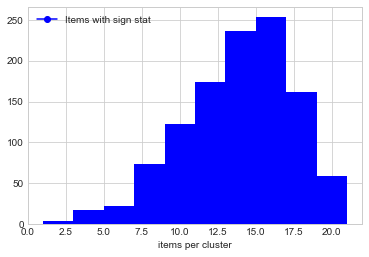

In [24]:
plt.hist(x['True'], color= 'blue')
plt.xlabel('items per cluster')
create_legend({'blue':'Items with sign stat'})
plt.savefig('./plots/items_per_cluster_good_top'+plot_name+'.png')
plt.show()

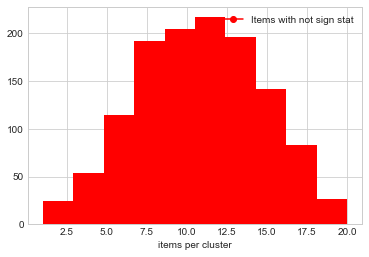

In [25]:
plt.hist(x['False'],color ='red')
plt.xlabel('items per cluster')
create_legend({'red':'Items with not sign stat'})
plt.savefig('./plots/items_per_cluster_bad_top'+plot_name+'.png')
plt.show()

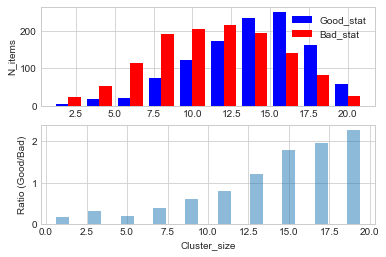

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=2)

ns, bins, patches = ax1.hist([x['True'],x['False']],
                      label=['Good_stat','Bad_stat'],
                      color = ['blue','red']
                      )

ax1.legend()

ax2.bar(bins[:-1],     # this is what makes it comparable
            ns[0] / ns[1], # maybe check for div-by-zero!
        alpha=0.5)

ax1.set_ylabel('N_items')
ax2.set_ylabel('Ratio (Good/Bad)')
ax2.set_xlabel('Cluster_size')


plt.savefig('./plots/ratio_cluster_size_bad_top'+plot_name+'.png')



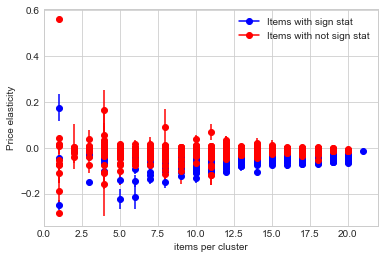

In [27]:
plt.errorbar(x['True'], y['True'], yerr=y_err['True'],fmt='o', c='blue')
plt.errorbar(x['False'], y['False'], yerr=y_err['False'],fmt='o',c='red')
plt.xlabel('items per cluster')
plt.ylabel('Price elasticity')


create_legend()
plt.savefig('./plots/PE_vs_items_per_cluster_top'+plot_name+'.png')
plt.show()



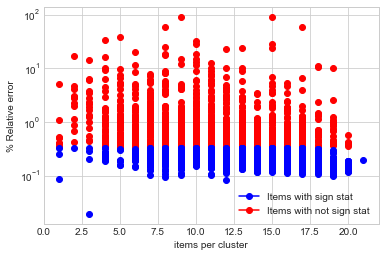

In [28]:
plt.scatter(x['False'],rel_err['False'],c='red')
plt.scatter(x['True'],rel_err['True'],c='blue')
plt.xlabel('items per cluster')
plt.ylabel('% Relative error')
plt.yscale('log')
create_legend()
plt.savefig('./plots/Relative_error_vs_items_per_cluster_top'+plot_name+'.png')
plt.show()

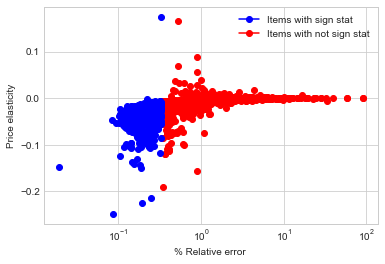

In [29]:
plt.scatter(rel_err['False'],y['False'],c='red')
plt.scatter(rel_err['True'],y['True'],c='blue')
plt.ylabel('Price elasticity')
plt.xlabel('% Relative error ')
plt.xscale('log')
#plt.yscale('log')
create_legend()
plt.savefig('./plots/Relative_error_vs_PE_top'+plot_name+'.png')
plt.show()



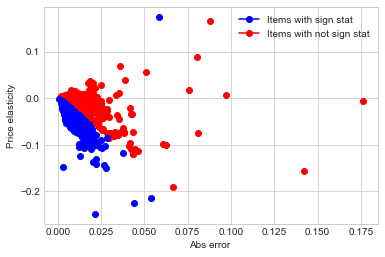

In [30]:
plt.scatter(y_err['False'],y['False'],c='red')
plt.scatter(y_err['True'],y['True'],c='blue')
plt.ylabel('Price elasticity')
plt.xlabel('Abs error ')
#plt.xscale('log')
create_legend()
plt.savefig('./plots/Abs_error_vs_PE_top'+plot_name+'.png')
plt.show()



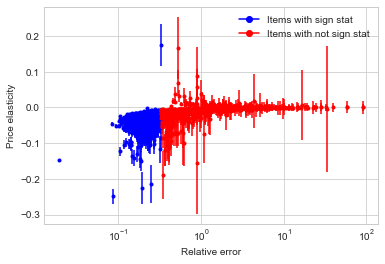

In [31]:
plt.errorbar(rel_err['True'], y['True'], yerr=y_err['True'],fmt='.', c='blue')
plt.errorbar(rel_err['False'], y['False'], yerr=y_err['False'],fmt='.',c='red')
plt.xlabel('Relative error')
plt.ylabel('Price elasticity')
plt.xscale('log')

create_legend()
plt.savefig('./plots/Rel_err_vs_PE_plus_abs_err_top'+plot_name+'.png')
plt.show()

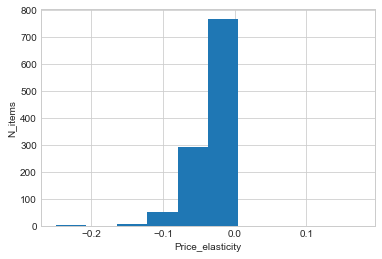

In [32]:
plt.hist(y['True'])
plt.xlabel('Price_elasticity')
plt.ylabel('N_items')
plt.savefig('./plots/PE_histo_top'+plot_name+'.png')
plt.show()


In [33]:
import statistics
print(statistics.median(y['True']))


-0.0268


In [34]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

y['True'].sort()
three_list = list(split(y['True'],3))


print(three_list[0][-1],three_list[1][-1] )

-0.036 -0.0206


In [35]:
df_result_true_high = df_result_true[df_result_true['PE'] <= three_list[0][-1] ]
print(len(df_result_true_high.index))
df_result_true_medium = df_result_true[ (df_result_true['PE'] > three_list[0][-1] ) & ( df_result_true['PE'] <= three_list[1][-1])]
print(len(df_result_true_medium.index))
df_result_true_low = df_result_true[df_result_true['PE'] > three_list[1][-1] ]
print(len(df_result_true_low.index))

375
375
374


In [36]:
list_high   = list(df_result_true_high.index)
list_medium = list(df_result_true_medium.index)
list_low    = list(df_result_true_low.index)
#print(df_result_true_high.index)

In [37]:
df_result_true_high.to_csv('./pickle_files/Top'+plot_name+'_high_el.csv')
df_result_true_medium.to_csv('./pickle_files/Top'+plot_name+'_medium_el.csv')
df_result_true_low.to_csv('./pickle_files/Top'+plot_name+'_low_el.csv')

In [38]:
import pickle
def save_obj(obj, name ):
    with open('pickle_files/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


In [39]:
#Read_item_code

df_reach = pd.read_csv('../raw_data/stock_av/item_code_stock_reach.csv',dtype = {'item_code':str})

#df_reach= df_reach.astype({'item_code': 'string'})
print(df_reach.dtypes)
avl_item = list(df_reach.item_code.values)
print(avl_item[0])

item_code                object
available_stock           int64
avg_sales_forecasted    float64
reach                   float64
dtype: object
000000001000208731


In [40]:
df_result_true = df_result_true[['PE','PE_err']]
#print(df_result_true.head())
#print(df_result_true.columns)

In [41]:
#df_result_true = df_result_true.rename(column_index={'':'item_code'})
print(df_result_true.head(1000))
print(df_result_true.dtypes)

                        PE  PE_err
000000001000021922 -0.0188  0.0034
000000001000126849 -0.0089  0.0029
000000001000005727 -0.0460  0.0073
000000001000007822 -0.0246  0.0073
000000001000116614 -0.0141  0.0030
...                    ...     ...
000000001000117172 -0.0360  0.0072
000000001000082095 -0.0170  0.0042
000000001000186228 -0.0158  0.0032
000000001000016023 -0.0488  0.0072
000000001000096490 -0.0352  0.0111

[1000 rows x 2 columns]
PE        float64
PE_err    float64
dtype: object


In [42]:
print(avl_item)

['000000001000208731', '000000001000174885', '000000001000174813', '000000001000224524', '000000001000075000', '000000001000174978', '000000001000092143', '000000001000075003', '000000001000208732', '000000001000090822', '000000001000208734', '000000001000119632', '000000001000215112', '000000001000164750', '000000001000208730', '000000001000174884', '000000001000208735', '000000001000101404', '000000001000187774', '000000001000075002', '000000001000074998', '000000001000224526', '000000001000092141', '000000001000090865', '000000001000174806', '000000001000072366', '000000001000174822', '000000001000174887', '000000001000174975', '000000001000174818', '000000001000215101', '000000001000208243', '000000001000092145', '000000001000208721', '000000001000215100', '000000001000092144', '000000001000174833', '000000001000151818', '000000001000187768', '000000001000135006', '000000001000021947', '000000001000191290', '000000001000125854', '000000001000231374', '000000001000104693', '00000000

In [43]:
df_stock_filt=df_result_true[df_result_true.index.isin(avl_item)]
print(df_stock_filt.head())

print(len(df_stock_filt.index))

                        PE  PE_err
000000001000005727 -0.0460  0.0073
000000001000007822 -0.0246  0.0073
000000001000008470 -0.0643  0.0105
000000001000022615 -0.0888  0.0186
000000001000008474 -0.0433  0.0123
395


In [44]:
#PREPARE THE CONVERSION RATE FILE
final_items = list(df_stock_filt.index.values)
print(len(final_items))



395


In [45]:
print(df_filt.head(10))

     min_date    max_date           item_code  item_price_x  delivery_weeks  \
0  2020-01-01  2020-03-13  000000001000021922        129.99               2   
1  2020-04-15  2020-04-21  000000001000021922        119.99               4   
2  2020-04-23  2020-06-07  000000001000021922        129.99               2   
3  2020-06-11  2020-07-25  000000001000021922        129.99               2   
4  2020-07-31  2020-08-10  000000001000021922        119.99               2   
5  2020-08-11  2020-08-18  000000001000021922        129.99               2   
6  2020-08-19  2020-08-25  000000001000021922        129.99               3   
7  2020-08-26  2020-09-17  000000001000021922        129.99               2   
8  2020-10-03  2020-10-13  000000001000021922        114.99               2   
9  2020-11-29  2020-12-06  000000001000021922        114.99              15   

   avg_sales  avg_unique_views  conv_rate  bin item_parent_item_code  \
0   2.547945        147.191781   0.017310   73  0000000010

In [46]:
df_final = df_filt[['item_code','max_date','item_price_x','conv_rate','avg_sales', 'avg_unique_views']]

print(df_final.head())

            item_code    max_date  item_price_x  conv_rate  avg_sales  \
0  000000001000021922  2020-03-13        129.99   0.017310   2.547945   
1  000000001000021922  2020-04-21        119.99   0.026978   2.142857   
2  000000001000021922  2020-06-07        129.99   0.032179   2.869565   
3  000000001000021922  2020-07-25        129.99   0.022216   1.644444   
4  000000001000021922  2020-08-10        119.99   0.024390   2.000000   

   avg_unique_views  
0        147.191781  
1         79.428571  
2         89.173913  
3         74.022222  
4         82.000000  


In [47]:
df_final= df_final[df_filt['item_code'].isin(final_items)]

In [48]:
print(df_final.head())

             item_code    max_date  item_price_x  conv_rate  avg_sales  \
47  000000001000005727  2020-01-15         99.99   0.013724   3.466667   
48  000000001000005727  2020-02-03         84.99   0.022294   7.263158   
49  000000001000005727  2020-05-03         99.99   0.018841   4.288889   
50  000000001000005727  2020-05-19         69.99   0.041957  24.500000   
51  000000001000005727  2020-07-31         99.99   0.019710   3.972603   

    avg_unique_views  
47        252.600000  
48        325.789474  
49        227.633333  
50        583.937500  
51        201.547945  


In [49]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
spark = SparkSession.builder.master('local').config('spark.driver.memory', '8g').appName('Ready_for_analysis').getOrCreate()

In [50]:
df_to_spark = df_final.groupby(['item_code']).nth(-1)
df_to_spark.reset_index(level=0,inplace=True)
df_to_spark.rename(columns={'index':'item_code'}, inplace=True)
spark_check = spark.createDataFrame(df_to_spark)


In [51]:
spark_check.show()

+------------------+----------+------------+--------------------+------------------+------------------+
|         item_code|  max_date|item_price_x|           conv_rate|         avg_sales|  avg_unique_views|
+------------------+----------+------------+--------------------+------------------+------------------+
|000000001000005177|2020-12-09|      799.99|0.007598039215686274|1.4090909090909092|             204.0|
|000000001000005222|2020-12-09|      179.99|  0.0446927374301676|1.3333333333333333|              35.8|
|000000001000005726|2020-12-09|       99.99| 0.02040816326530612|1.6666666666666667|             105.0|
|000000001000005727|2020-12-09|       99.99|0.038753159224936815| 5.111111111111111|169.57142857142858|
|000000001000005736|2020-12-09|       59.99|0.043239319784321856|           2.60625|61.037974683544306|
|000000001000005775|2020-12-09|       99.99| 0.05555555555555555|             1.625|              39.0|
|000000001000006076|2020-12-09|      199.99|0.023728813559322035

In [52]:
spark_df = spark.createDataFrame(df_final)

In [53]:
spark_df.createOrReplaceTempView('Final_table')


In [54]:
spark_last_price = spark.sql("""with max_price as (SELECT item_code, ROW_NUMBER() over (PARTITION BY item_code ORDER BY max_date DESC) as rn, item_price_x, max_date
                            from Final_table)
                            SELECT item_code, item_price_x, max_date
                            from max_price
                            where rn=1
                            """)
spark_last_price.show()

+------------------+------------+----------+
|         item_code|item_price_x|  max_date|
+------------------+------------+----------+
|000000001000024320|      119.99|2020-12-01|
|000000001000005727|       99.99|2020-12-09|
|000000001000007822|      279.99|2020-05-27|
|000000001000114877|      179.99|2020-12-09|
|000000001000185455| 99.98999999|2020-09-13|
|000000001000008470|       99.99|2020-12-09|
|000000001000022615|       34.99|2020-12-09|
|000000001000182807|      749.99|2020-05-11|
|000000001000008474|      129.99|2020-11-11|
|000000001000008491|      129.99|2020-10-29|
|000000001000174114|      114.99|2020-12-09|
|000000001000061845|      399.99|2020-12-09|
|000000001000065698|      249.99|2020-12-09|
|000000001000022482|      144.99|2020-12-07|
|000000001000054183|      169.99|2020-12-09|
|000000001000173830|      819.99|2020-11-08|
|000000001000016092|      329.99|2020-12-09|
|000000001000063634|      164.99|2020-12-09|
|000000001000092325|      279.99|2020-11-26|
|000000001

In [55]:
spark_last_price.createOrReplaceTempView('last_price')


In [56]:
spark_check.createOrReplaceTempView('check_last_price')


In [57]:
disjoint_spark = spark.sql("""SELECT *
                                from check_last_price as clp
                                inner join last_price as lp on lp.item_code = clp.item_code and lp.item_price_x!= clp.item_price_x  """)

disjoint_spark.show()

+---------+--------+------------+---------+---------+----------------+---------+------------+--------+
|item_code|max_date|item_price_x|conv_rate|avg_sales|avg_unique_views|item_code|item_price_x|max_date|
+---------+--------+------------+---------+---------+----------------+---------+------------+--------+
+---------+--------+------------+---------+---------+----------------+---------+------------+--------+



In [58]:
spark_filter = spark.sql("""SELECT ft.item_code, AVG(ft.conv_rate) as avg_conv_rate, MAX(ft.item_price_x) as last_price, MAX(ft.max_date) as last_date, AVG(avg_unique_views) as avg_unique_views
                            from Final_table as ft
                            inner join last_price as lp on lp.item_code = ft.item_code and lp.item_price_x = ft.item_price_x
                            GROUP BY ft.item_code
                            """)
spark_filter.show()

+------------------+--------------------+-----------+----------+------------------+
|         item_code|       avg_conv_rate| last_price| last_date|  avg_unique_views|
+------------------+--------------------+-----------+----------+------------------+
|000000001000024320| 0.06782106782106782|     119.99|2020-12-01| 22.35483870967742|
|000000001000185455|0.037324055037165904|99.98999999|2020-09-13| 69.48351648351648|
|000000001000114877|0.014925242787448221|     179.99|2020-12-09|193.82021563342317|
|000000001000007822| 0.01959085148854948|     279.99|2020-05-27| 112.2716049382716|
|000000001000005727|0.029960521218307824|      99.99|2020-12-09|176.11904761904762|
|000000001000008470| 0.04373449131513648|      99.99|2020-12-09| 87.13513513513513|
|000000001000182807|0.015217391304347827|     749.99|2020-05-11| 65.71428571428571|
|000000001000022615| 0.09241841741466929|      34.99|2020-12-09| 53.87131198995605|
|000000001000008474| 0.02329699224653561|     129.99|2020-11-11|129.68050716

In [59]:
spark_filter.createOrReplaceTempView('Final_table_filt')



In [60]:

df_stock_filt.reset_index(level=0,inplace=True)



In [61]:
df_stock_filt.rename(columns={'index':'item_code'}, inplace=True)

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/pandas/core/frame.py:4290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [62]:
print(df_stock_filt.head())

            item_code      PE  PE_err
0  000000001000005727 -0.0460  0.0073
1  000000001000007822 -0.0246  0.0073
2  000000001000008470 -0.0643  0.0105
3  000000001000022615 -0.0888  0.0186
4  000000001000008474 -0.0433  0.0123


In [63]:
spark_PE_df = spark.createDataFrame(df_stock_filt )

In [64]:
spark_PE_df.show()

+------------------+-------+------+
|         item_code|     PE|PE_err|
+------------------+-------+------+
|000000001000005727| -0.046|0.0073|
|000000001000007822|-0.0246|0.0073|
|000000001000008470|-0.0643|0.0105|
|000000001000022615|-0.0888|0.0186|
|000000001000008474|-0.0433|0.0123|
|000000001000008491|-0.0385|0.0094|
|000000001000061845|-0.0254| 0.006|
|000000001000065698|-0.0241|0.0068|
|000000001000054183|-0.0123|0.0025|
|000000001000173830|-0.0192|0.0053|
|000000001000092325|-0.0134|0.0044|
|000000001000012569|-0.0135|0.0041|
|000000001000016014|-0.0409|0.0076|
|000000001000123698|-0.0267|0.0046|
|000000001000118214|-0.0298|0.0058|
|000000001000123220|-0.0311|0.0044|
|000000001000050850| -0.059|0.0088|
|000000001000056199|-0.0501|0.0136|
|000000001000006422|-0.0246|0.0058|
|000000001000008748|-0.0166|0.0049|
+------------------+-------+------+
only showing top 20 rows



In [65]:
spark_PE_df.createOrReplaceTempView('final_PE')

In [66]:
spark_final = spark.sql("""SELECT ftf.*, fpe.PE, fpe.PE_err
                            from Final_table_filt as ftf
                            INNER JOIN final_PE as fpe on fpe.item_code = ftf.item_code""")
spark_final.show()
spark_final.createOrReplaceTempView('spark_final_tmp')

+------------------+--------------------+-----------+----------+------------------+-------+------+
|         item_code|       avg_conv_rate| last_price| last_date|  avg_unique_views|     PE|PE_err|
+------------------+--------------------+-----------+----------+------------------+-------+------+
|000000001000024320| 0.06782106782106782|     119.99|2020-12-01| 22.35483870967742|-0.0854| 0.018|
|000000001000005727|0.029960521218307824|      99.99|2020-12-09|176.11904761904762| -0.046|0.0073|
|000000001000007822| 0.01959085148854948|     279.99|2020-05-27| 112.2716049382716|-0.0246|0.0073|
|000000001000114877|0.014925242787448221|     179.99|2020-12-09|193.82021563342317|-0.0218|0.0049|
|000000001000185455|0.037324055037165904|99.98999999|2020-09-13| 69.48351648351648| 0.1748|0.0582|
|000000001000008470| 0.04373449131513648|      99.99|2020-12-09| 87.13513513513513|-0.0643|0.0105|
|000000001000022615| 0.09241841741466929|      34.99|2020-12-09| 53.87131198995605|-0.0888|0.0186|
|000000001

In [67]:
#Introduce d_item table
sp_df_item = spark.read.parquet(
    '/Users/gabriele.sabato/PycharmProjects/raw_data/redshift_tables/d_item/*.parquet',
    header=True)
sp_df_item.show()

+---------------+------------------+---------------------+-------------+----------------+----------+-------------+-----------+----------+-----------+--------------+-------------+--------------------+----------------------+--------------------+------------------+--------------------+------------------+-------------------+-------------------+---------+--------------------------------+---------------------------------------------+-----------------------+---------------------+------------------------+--------------------------+------------------------+--------------------+-----------+-------------------+------------------+-------------------+----------------------------+---------------+-----------------------+-----------------------+----------------------+------------------------------------+-------------------------------------------+-------------------------------------------------+--------------------------------------------------------+
|      item_skey|         item_code|item_parent_i

In [68]:
#Introduce PC2 table
sp_df_pc2 = spark.read.parquet(
    '/Users/gabriele.sabato/PycharmProjects/raw_data/redshift_tables/f_item_status_last/*.parquet',
    header=True)
sp_df_pc2.show()

+-----------+---------+----------------+-----------------------+--------------------------+--------------------------+--------------------------+--------------------------------+---------------------------------+---------------------------------------+
|  item_skey|shop_skey|item_status_skey|item_status_weekly_skey|item_pc1_costs_before_cogs|item_pc2_costs_before_cogs|group_pc2_margin_simulated|group_pc2_margin_ratio_simulated|group_pc2_margin_simulated_pocket|group_pc2_margin_ratio_simulated_pocket|
+-----------+---------+----------------+-----------------------+--------------------------+--------------------------+--------------------------+--------------------------------+---------------------------------+---------------------------------------+
| 4226129468|        1|               4|                      4|                    26.070|                    28.239|                      null|                            null|                             null|                             

In [69]:
sp_df_item.createOrReplaceTempView('d_item_tmp')
sp_df_pc2.createOrReplaceTempView('d_item_pc2')

In [70]:
pc2_table = spark.sql(""" WITH pc2_avg as (
                            SELECT item_skey,
                            item_pc2_costs_before_cogs as pc2
                            from d_item_pc2
                            where shop_skey = 1)
                            SELECT di.item_code, pc.pc2
                            from d_item_tmp as di
                            INNER JOIN pc2_avg as pc on pc.item_skey = di.item_skey
                            where di.item_code like '0%'
                            """)
pc2_table.show()


+------------------+--------+
|         item_code|     pc2|
+------------------+--------+
|000000001000179891|  28.239|
|000000001000036224|  96.939|
|000000001000209207| 165.440|
|000000001000119994|    null|
|000000001000204409|  35.520|
|000000001000136606|  56.909|
|000000001000160767| 353.079|
|000000001000165619|  28.840|
|000000001000200088| 725.289|
|000000001000102599| 696.340|
|000000001000004274| 424.970|
|000000001000221236|  82.980|
|000000001000116408| 118.370|
|000000001000026105|  63.159|
|000000001000124118|  89.319|
|000000001000224401|  74.900|
|000000001000162724|  22.039|
|000000001000208117|2212.239|
|000000001000054905| 224.699|
|000000001000012343| 222.889|
+------------------+--------+
only showing top 20 rows



In [71]:
pc2_table.createOrReplaceTempView('pc2_table')

In [72]:
spark_pc2_final = spark.sql(""" SELECT sp.*, pc.pc2
                                from spark_final_tmp as sp
                                 INNER JOIN pc2_table as pc on sp.item_code = pc.item_code
                                 """)

spark_pc2_final.show()

+------------------+--------------------+-----------+----------+------------------+-------+------+-------+
|         item_code|       avg_conv_rate| last_price| last_date|  avg_unique_views|     PE|PE_err|    pc2|
+------------------+--------------------+-----------+----------+------------------+-------+------+-------+
|000000001000024320| 0.06782106782106782|     119.99|2020-12-01| 22.35483870967742|-0.0854| 0.018| 65.109|
|000000001000005727|0.029960521218307824|      99.99|2020-12-09|176.11904761904762| -0.046|0.0073| 41.450|
|000000001000007822| 0.01959085148854948|     279.99|2020-05-27| 112.2716049382716|-0.0246|0.0073|109.170|
|000000001000114877|0.014925242787448221|     179.99|2020-12-09|193.82021563342317|-0.0218|0.0049| 77.859|
|000000001000185455|0.037324055037165904|99.98999999|2020-09-13| 69.48351648351648| 0.1748|0.0582| 40.140|
|000000001000008470| 0.04373449131513648|      99.99|2020-12-09| 87.13513513513513|-0.0643|0.0105| 49.380|
|000000001000022615| 0.09241841741466

In [188]:

df_final_spark = spark_pc2_final.toPandas()

In [189]:
import math
import numpy as np


In [190]:
df_final_spark=df_final_spark.astype({'pc2': 'float64'})

print(df_final_spark.dtypes)

df_final_spark.dropna(inplace=True)

item_code            object
avg_conv_rate       float64
last_price          float64
last_date            object
avg_unique_views    float64
PE                  float64
PE_err              float64
pc2                 float64
dtype: object


In [191]:
df_final_spark= df_final_spark[df_final_spark['PE'] < 0]


In [192]:
VAT = 1.19



In [193]:
def create_Margin( increment = 0.01,dataf= df_final_spark,):

    #dataf['price_up']   = dataf['last_price']*math.exp(increment)
    dataf['price_down'] = dataf['last_price']*math.exp(-increment)
    #dataf['conv_rate_up'] =   dataf['avg_conv_rate']*np.exp(dataf['PE']*np.log(dataf['price_up']/dataf['last_price']))
    dataf['conv_rate_down'] = dataf['avg_conv_rate']*np.exp(dataf['PE']*np.log(dataf['price_down']/dataf['last_price']))
    #dataf['conv_rate_up_err']   = np.fabs(dataf['conv_rate_up'])*np.fabs(dataf['PE_err']*np.log(dataf['price_up']/dataf['last_price']))
    dataf['conv_rate_down_err'] = np.fabs(dataf['conv_rate_down'])*np.fabs(dataf['PE_err']*np.log(dataf['price_down']/dataf['last_price']))

    dataf['Delta_price'] = (dataf['last_price']/VAT - dataf['pc2'])
    #dataf['Margin_up']     = dataf['avg_unique_views']*dataf['conv_rate_up']*(dataf['Delta_price'])
    dataf['Margin_down']   = dataf['avg_unique_views']*dataf['conv_rate_down']*(dataf['Delta_price'])
    if increment == 0.01:
        dataf['Margin_base']   = dataf['avg_unique_views']*dataf['avg_conv_rate']*(dataf['Delta_price'])

    #Propagate Margin error
    #dataf['Margin_up_err']     = dataf['avg_unique_views']*dataf['conv_rate_up_err']*(dataf['Delta_price'])
    dataf['Margin_down_err']   = dataf['avg_unique_views']*dataf['conv_rate_down_err']*(dataf['Delta_price'])

    #dataf['Group_flag'] = np.where(dataf['Margin_base'] < (dataf['Margin_up'] - 3*dataf['Margin_up_err']), 'up',
    #                                    np.where(dataf['Margin_base'] < (dataf['Margin_down'] - 3*dataf['Margin_down_err']), 'down','neutral'))
    dataf['Group_flag'] = np.where(dataf['Margin_base'] < (dataf['Margin_down'] - 3*dataf['Margin_down_err']), 'down','neutral')




In [194]:
print(df_final_spark[['item_code','avg_conv_rate','last_price']].head())
#create_Margin(0.01)

            item_code  avg_conv_rate  last_price
0  000000001000024320       0.067821      119.99
1  000000001000005727       0.029961       99.99
2  000000001000007822       0.019591      279.99
3  000000001000114877       0.014925      179.99
5  000000001000008470       0.043734       99.99


In [195]:
original_df= df_final_spark
tmp_df = pd.DataFrame()


In [196]:
for inc in np.linspace(0.01,0.1,10):
    print('Increment = ' + str(inc))
    create_Margin(inc,original_df)
    #print(original_df)
    tmp_df = tmp_df.append(original_df[original_df['Group_flag'] == 'neutral'])
    original_df = original_df[original_df['Group_flag'] != 'neutral']
    #original_df['last_price']    = original_df['price_down']
    #original_df['avg_conv_rate'] = original_df['conv_rate_down']
    original_df['Margin_base']   = original_df['Margin_down']
    #print(original_df[['item_code','avg_conv_rate','conv_rate_down','last_price','price_down','Margin_base','Margin_down']].head())
    print(len(original_df.index))
    print(len(tmp_df.index))



Increment = 0.01
392
0
Increment = 0.020000000000000004
86
306
Increment = 0.030000000000000006
7
385
Increment = 0.04000000000000001
0
392
Increment = 0.05000000000000001
0
392
Increment = 0.06000000000000001
0
392
Increment = 0.07
0
392
Increment = 0.08
0
392
Increment = 0.09000000000000001
0
392
Increment = 0.1
0
392


In [197]:
df_final_spark.head(400)


,item_code,avg_conv_rate,last_price,last_date,avg_unique_views,PE,PE_err,pc2,price_down,conv_rate_down,conv_rate_down_err,Delta_price,Margin_down,Margin_base,Margin_down_err,Group_flag
0,000000001000024320,0.067821,119.99,2020-12-01,22.354839,-0.0854,0.0180,65.109,118.796080,0.067879,1.221822e-05,35.722933,54.206848,54.160575,0.009757,down
1,000000001000005727,0.029961,99.99,2020-12-09,176.119048,-0.0460,0.0073,41.450,98.995083,0.029974,2.188124e-06,42.575210,224.756504,224.653140,0.016407,down
2,000000001000007822,0.019591,279.99,2020-05-27,112.271605,-0.0246,0.0073,109.170,277.204053,0.019596,1.430484e-06,126.115714,277.459298,277.391052,0.020255,down
3,000000001000114877,0.014925,179.99,2020-12-09,193.820216,-0.0218,0.0049,77.859,178.199070,0.014928,7.314963e-07,73.393101,212.358862,212.312573,0.010406,down
5,000000001000008470,0.043734,99.99,2020-12-09,87.135135,-0.0643,0.0105,49.380,98.995083,0.043763,4.595075e-06,34.645210,132.111261,132.026341,0.013872,down
6,000000001000022615,0.092418,34.99,2020-12-09,53.871312,-0.0888,0.0186,12.359,34.641844,0.092501,1.720510e-05,17.044361,84.934174,84.858786,0.015798,down
7,000000001000182807,0.015217,749.99,2020-05-11,65.714286,-0.0269,0.0057,337.029,742.527475,0.015221,8.676247e-07,293.214697,293.293583,293.214697,0.016718,down
8,000000001000008474,0.023297,129.99,2020-11-11,129.680507,-0.0433,0.0123,61.280,128.696578,0.023307,2.866771e-06,47.955294,144.943640,144.880893,0.017828,down
9,000000001000008491,0.003579,129.99,2020-10-29,330.075926,-0.0385,0.0094,54.670,128.696578,0.003580,3.365344e-07,54.565294,64.481035,64.456215,0.006061,down
10,000000001000174114,0.029125,114.99,2020-12-09,281.417749,-0.0319,0.0054,76.790,113.845830,0.029134,1.573233e-06,19.840252,162.666455,162.614573,0.008784,down


In [198]:
tmp_df.head(400)


,item_code,avg_conv_rate,last_price,last_date,avg_unique_views,PE,PE_err,pc2,price_down,conv_rate_down,conv_rate_down_err,Delta_price,Margin_down,Margin_base,Margin_down_err,Group_flag
0,000000001000024320,0.067821,119.99,2020-12-01,22.354839,-0.0854,0.0180,65.109,117.614039,0.067937,2.445732e-05,35.722933,54.253161,54.206848,0.019531,neutral
2,000000001000007822,0.019591,279.99,2020-05-27,112.271605,-0.0246,0.0073,109.170,274.445827,0.019600,2.861672e-06,126.115714,277.527562,277.459298,0.040519,neutral
3,000000001000114877,0.014925,179.99,2020-12-09,193.820216,-0.0218,0.0049,77.859,176.425959,0.014932,1.463312e-06,73.393101,212.405162,212.358862,0.020816,neutral
6,000000001000022615,0.092418,34.99,2020-12-09,53.871312,-0.0888,0.0186,12.359,34.297152,0.092583,3.444076e-05,17.044361,85.009629,84.934174,0.031624,neutral
7,000000001000182807,0.015217,749.99,2020-05-11,65.714286,-0.0269,0.0057,337.029,735.139203,0.015226,1.735716e-06,293.214697,293.372489,293.293583,0.033444,neutral
8,000000001000008474,0.023297,129.99,2020-11-11,129.680507,-0.0433,0.0123,61.280,127.416026,0.023317,5.736025e-06,47.955294,145.006414,144.943640,0.035672,neutral
9,000000001000008491,0.003579,129.99,2020-10-29,330.075926,-0.0385,0.0094,54.670,127.416026,0.003582,6.733280e-07,54.565294,64.505865,64.481035,0.012127,neutral
10,000000001000174114,0.029125,114.99,2020-12-09,281.417749,-0.0319,0.0054,76.790,112.713045,0.029143,3.147470e-06,19.840252,162.718354,162.666455,0.017574,neutral
11,000000001000061845,0.009895,399.99,2020-12-09,117.896825,-0.0254,0.0060,228.340,392.069667,0.009900,1.188036e-06,107.786050,125.809429,125.777478,0.015097,neutral
12,000000001000065698,0.005526,249.99,2020-12-09,150.831384,-0.0241,0.0068,178.270,245.039866,0.005529,7.518813e-07,31.805630,26.521989,26.515598,0.003607,neutral


In [199]:
tmp_df = tmp_df.sort_index()

In [200]:
tmp_df['Margin_last'] = tmp_df['Margin_base']
tmp_df.head()

,item_code,avg_conv_rate,last_price,last_date,avg_unique_views,PE,PE_err,pc2,price_down,conv_rate_down,conv_rate_down_err,Delta_price,Margin_down,Margin_base,Margin_down_err,Group_flag,Margin_last
0,000000001000024320,0.067821,119.99,2020-12-01,22.354839,-0.0854,0.0180,65.109,117.614039,0.067937,0.000024,35.722933,54.253161,54.206848,0.019531,neutral,54.206848
1,000000001000005727,0.029961,99.99,2020-12-09,176.119048,-0.0460,0.0073,41.450,97.034849,0.030002,0.000007,42.575210,224.963375,224.859916,0.049267,neutral,224.859916
2,000000001000007822,0.019591,279.99,2020-05-27,112.271605,-0.0246,0.0073,109.170,274.445827,0.019600,0.000003,126.115714,277.527562,277.459298,0.040519,neutral,277.459298
3,000000001000114877,0.014925,179.99,2020-12-09,193.820216,-0.0218,0.0049,77.859,176.425959,0.014932,0.000001,73.393101,212.405162,212.358862,0.020816,neutral,212.358862
5,000000001000008470,0.043734,99.99,2020-12-09,87.135135,-0.0643,0.0105,49.380,97.034849,0.043819,0.000014,34.645210,132.281266,132.196236,0.041669,neutral,132.196236


In [201]:
create_Margin(0.01,df_final_spark)
df_final_spark.head()

,item_code,avg_conv_rate,last_price,last_date,avg_unique_views,PE,PE_err,pc2,price_down,conv_rate_down,conv_rate_down_err,Delta_price,Margin_down,Margin_base,Margin_down_err,Group_flag
0,000000001000024320,0.067821,119.99,2020-12-01,22.354839,-0.0854,0.0180,65.109,118.796080,0.067879,1.221822e-05,35.722933,54.206848,54.160575,0.009757,down
1,000000001000005727,0.029961,99.99,2020-12-09,176.119048,-0.0460,0.0073,41.450,98.995083,0.029974,2.188124e-06,42.575210,224.756504,224.653140,0.016407,down
2,000000001000007822,0.019591,279.99,2020-05-27,112.271605,-0.0246,0.0073,109.170,277.204053,0.019596,1.430484e-06,126.115714,277.459298,277.391052,0.020255,down
3,000000001000114877,0.014925,179.99,2020-12-09,193.820216,-0.0218,0.0049,77.859,178.199070,0.014928,7.314963e-07,73.393101,212.358862,212.312573,0.010406,down
5,000000001000008470,0.043734,99.99,2020-12-09,87.135135,-0.0643,0.0105,49.380,98.995083,0.043763,4.595075e-06,34.645210,132.111261,132.026341,0.013872,down


In [183]:
tmp_df['Margin_base']=df_final_spark['Margin_base']

tmp_df['Margin_rate_to_base'] = np.log(tmp_df['Margin_down']/tmp_df['Margin_base'])
#tmp_df['Margin_rate_to_last'] = np.log(tmp_df['Margin_down']/tmp_df['Margin_last'])

In [204]:
tmp_df[['item_code','avg_conv_rate'	,'last_price','avg_unique_views', 'price_down', 'Delta_price', 'Margin_down','Margin_base','Margin_down_err','Margin_last','Group_flag','Margin_rate_to_base']]

KeyError: "['Margin_rate_to_base'] not in index"

In [203]:
print(tmp_df['Margin_rate_to_base'].mean()*100)

KeyError: 'Margin_rate_to_base'

In [87]:
print(df_final_spark.head())

            item_code  avg_conv_rate  last_price   last_date  \
0  000000001000024320       0.067879  118.796080  2020-12-01   
1  000000001000005727       0.029974   98.995083  2020-12-09   
2  000000001000007822       0.019596  277.204053  2020-05-27   
3  000000001000114877       0.014928  178.199070  2020-12-09   
5  000000001000008470       0.043763   98.995083  2020-12-09   

   avg_unique_views      PE  PE_err      pc2    price_up  price_down  ...  \
0         22.354839 -0.0854  0.0180   65.109  121.195920  118.796080  ...   
1        176.119048 -0.0460  0.0073   41.450  100.994916   98.995083  ...   
2        112.271605 -0.0246  0.0073  109.170  282.803946  277.204053  ...   
3        193.820216 -0.0218  0.0049   77.859  181.798930  178.199070  ...   
5         87.135135 -0.0643  0.0105   49.380  100.994916   98.995083  ...   

   conv_rate_down  conv_rate_up_err  conv_rate_down_err  Delta_price  \
0        0.067879      1.219737e-05        1.221822e-05       54.881   
1       

In [ ]:
df_final_spark['price_up'] = df_final_spark['last_price']*math.exp(0.01)
df_final_spark['price_down'] = df_final_spark['last_price']*math.exp(-0.01)



In [137]:
print(df_final_spark.head())
print(df_final_spark.dtypes)

            item_code  avg_conv_rate  last_price   last_date  \
0  000000001000024320       0.067821      119.99  2020-12-01   
1  000000001000005727       0.029961       99.99  2020-12-09   
2  000000001000007822       0.019591      279.99  2020-05-27   
3  000000001000114877       0.014925      179.99  2020-12-09   
4  000000001000185455       0.037324       99.99  2020-09-13   

   avg_unique_views      PE  PE_err      pc2    price_up  price_down  
0         22.354839 -0.0854  0.0180   65.109  121.195920  118.796080  
1        176.119048 -0.0460  0.0073   41.450  100.994916   98.995083  
2        112.271605 -0.0246  0.0073  109.170  282.803946  277.204053  
3        193.820216 -0.0218  0.0049   77.859  181.798930  178.199070  
4         69.483516  0.1748  0.0582   40.140  100.994916   98.995083  
item_code            object
avg_conv_rate       float64
last_price          float64
last_date            object
avg_unique_views    float64
PE                  float64
PE_err              f

In [138]:
df_final_spark['conv_rate_up'] =   df_final_spark['avg_conv_rate']*np.exp(df_final_spark['PE']*np.log(df_final_spark['price_up']/df_final_spark['last_price']))
df_final_spark['conv_rate_down'] = df_final_spark['avg_conv_rate']*np.exp(df_final_spark['PE']*np.log(df_final_spark['price_down']/df_final_spark['last_price']))

In [139]:
print(df_final_spark.head())

            item_code  avg_conv_rate  last_price   last_date  \
0  000000001000024320       0.067821      119.99  2020-12-01   
1  000000001000005727       0.029961       99.99  2020-12-09   
2  000000001000007822       0.019591      279.99  2020-05-27   
3  000000001000114877       0.014925      179.99  2020-12-09   
4  000000001000185455       0.037324       99.99  2020-09-13   

   avg_unique_views      PE  PE_err      pc2    price_up  price_down  \
0         22.354839 -0.0854  0.0180   65.109  121.195920  118.796080   
1        176.119048 -0.0460  0.0073   41.450  100.994916   98.995083   
2        112.271605 -0.0246  0.0073  109.170  282.803946  277.204053   
3        193.820216 -0.0218  0.0049   77.859  181.798930  178.199070   
4         69.483516  0.1748  0.0582   40.140  100.994916   98.995083   

   conv_rate_up  conv_rate_down  
0      0.067763        0.067879  
1      0.029947        0.029974  
2      0.019586        0.019596  
3      0.014922        0.014928  
4      0.037

In [140]:
df_final_spark['conv_rate_up_err']   = np.fabs(df_final_spark['conv_rate_up'])*np.fabs(df_final_spark['PE_err']*np.log(df_final_spark['price_up']/df_final_spark['last_price']))
df_final_spark['conv_rate_down_err'] = np.fabs(df_final_spark['conv_rate_down'])*np.fabs(df_final_spark['PE_err']*np.log(df_final_spark['price_down']/df_final_spark['last_price']))

In [141]:
print(df_final_spark.head())


            item_code  avg_conv_rate  last_price   last_date  \
0  000000001000024320       0.067821      119.99  2020-12-01   
1  000000001000005727       0.029961       99.99  2020-12-09   
2  000000001000007822       0.019591      279.99  2020-05-27   
3  000000001000114877       0.014925      179.99  2020-12-09   
4  000000001000185455       0.037324       99.99  2020-09-13   

   avg_unique_views      PE  PE_err      pc2    price_up  price_down  \
0         22.354839 -0.0854  0.0180   65.109  121.195920  118.796080   
1        176.119048 -0.0460  0.0073   41.450  100.994916   98.995083   
2        112.271605 -0.0246  0.0073  109.170  282.803946  277.204053   
3        193.820216 -0.0218  0.0049   77.859  181.798930  178.199070   
4         69.483516  0.1748  0.0582   40.140  100.994916   98.995083   

   conv_rate_up  conv_rate_down  conv_rate_up_err  conv_rate_down_err  
0      0.067763        0.067879      1.219737e-05        1.221822e-05  
1      0.029947        0.029974      2

In [142]:
print(df_final_spark.dtypes)

item_code              object
avg_conv_rate         float64
last_price            float64
last_date              object
avg_unique_views      float64
PE                    float64
PE_err                float64
pc2                   float64
price_up              float64
price_down            float64
conv_rate_up          float64
conv_rate_down        float64
conv_rate_up_err      float64
conv_rate_down_err    float64
dtype: object


In [143]:
df_final_spark['Delta_price'] = (df_final_spark['last_price'] - df_final_spark['pc2'])
df_final_spark['Margin_up']     = df_final_spark['avg_unique_views']*df_final_spark['conv_rate_up']*(df_final_spark['Delta_price'])
df_final_spark['Margin_down']   = df_final_spark['avg_unique_views']*df_final_spark['conv_rate_down']*(df_final_spark['Delta_price'])
df_final_spark['Margin_base']   = df_final_spark['avg_unique_views']*df_final_spark['avg_conv_rate']*(df_final_spark['Delta_price'])

In [144]:
#Propagate Margin error
df_final_spark['Margin_up_err']     = df_final_spark['avg_unique_views']*df_final_spark['conv_rate_up_err']*(df_final_spark['Delta_price'])
df_final_spark['Margin_down_err']   = df_final_spark['avg_unique_views']*df_final_spark['conv_rate_down_err']*(df_final_spark['Delta_price'])

In [145]:
df_final_spark['Group_flag'] = np.where(df_final_spark['Margin_base'] < (df_final_spark['Margin_up'] - 3*df_final_spark['Margin_up_err']), 'up',
                                        np.where(df_final_spark['Margin_base'] < (df_final_spark['Margin_down'] - 3*df_final_spark['Margin_down_err']), 'down','neutral'))

In [147]:
print(df_final_spark[['Margin_base','Margin_up','Margin_down', 'Margin_up_err','Group_flag']].head(400))

     Margin_base    Margin_up  Margin_down  Margin_up_err Group_flag
0      83.206677    83.135649    83.277766       0.014964       down
1     308.893245   308.751187   309.035368       0.022539       down
2     375.717965   375.625549   375.810403       0.027421       down
3     295.445964   295.381563   295.510378       0.014474       down
4     155.215385   155.486938   154.944305       0.090493         up
5     192.865135   192.741163   192.989187       0.020238       down
6     112.672991   112.572982   112.773089       0.020939       down
7     412.961000   412.849928   413.072101       0.023532       down
8     207.584300   207.494436   207.674204       0.025522       down
9      88.973077    88.938829    89.007338       0.008360       down
10    313.094645   312.994784   313.194538       0.016902       down
11    200.250597   200.199740   200.301467       0.012012       down
12     59.776852    59.762447    59.791260       0.004064       down
13    111.050363   110.942475   11

In [148]:
print(df_final_spark.head(400))

              item_code  avg_conv_rate  last_price   last_date  \
0    000000001000024320       0.067821      119.99  2020-12-01   
1    000000001000005727       0.029961       99.99  2020-12-09   
2    000000001000007822       0.019591      279.99  2020-05-27   
3    000000001000114877       0.014925      179.99  2020-12-09   
4    000000001000185455       0.037324       99.99  2020-09-13   
5    000000001000008470       0.043734       99.99  2020-12-09   
6    000000001000022615       0.092418       34.99  2020-12-09   
7    000000001000182807       0.015217      749.99  2020-05-11   
8    000000001000008474       0.023297      129.99  2020-11-11   
9    000000001000008491       0.003579      129.99  2020-10-29   
10   000000001000174114       0.029125      114.99  2020-12-09   
11   000000001000061845       0.009895      399.99  2020-12-09   
12   000000001000065698       0.005526      249.99  2020-12-09   
13   000000001000022482       0.064091      144.99  2020-12-07   
14   00000

In [ ]:
#df_final_spark['Relative_diff_down_base'] = (df_final_spark['conv_rate_down']-df_final_spark['avg(conv_rate)'])/df_final_spark['avg(conv_rate)']*100

In [ ]:
#df_final_spark['Relative_diff_up_base'] = (df_final_spark['conv_rate_up']-df_final_spark['avg(conv_rate)'])/df_final_spark['avg(conv_rate)']*100

In [ ]:
#print(df_final_spark[['avg(conv_rate)','conv_rate_up','conv_rate_down','Relative_diff_down_base','Relative_diff_up_base']].head(400))

In [155]:
df_final_spark[['item_code','Group_flag']].head(10)

,item_code,Group_flag
0,000000001000024320,down
1,000000001000005727,down
2,000000001000007822,down
3,000000001000114877,down
4,000000001000185455,up
5,000000001000008470,down
6,000000001000022615,down
7,000000001000182807,down
8,000000001000008474,down
9,000000001000008491,down


In [ ]:
#df_final_spark.columns = ['item_code','conv_rate','price','last_date','PE','PE_err','price_up','price_down','conv_rate_up','conv_rate_down','conv_rate_up_err','conv_rate_down_err','Group_flag','Rel_diff_down_%','Rel_diff_up_%']

In [ ]:
#df_final_spark.head(500)

In [150]:
df_final_spark.to_csv('../raw_data/Excel_files/final_result_PE_analysis_PC2.csv')